# Constants

In [ ]:
tasks = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
            'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
            'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
excluded = ['dm1', 'dm2', 'contextdm1', 'contextdm2','multidm']

network_folder = "networks_24"

# Training

* Trains over all the pairs of tasks and saves each network on a specified directory.


In [ ]:
#alltask trainer
import train
from analysis import performance

import matplotlib.pyplot as plt
import tools
import numpy as np
from task import generate_trials, rule_name, get_dist

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

import tensorflow as tf

# Configure TF to use single thread
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)


def trainpair(task1,task2,hnodes=32,netfolder="networks/"):
    netname = "_".join(["laconeu",task1,task2,str(hnodes)])
    train.train(model_dir=netfolder+netname, 
            hp={'learning_rate': 0.001, 
                'n_rnn': hnodes,#512, 16384,8192,1024
                # 'w_rec_init': 'randgauss',#'randortho'
                # 'b_rec_init': 'uniform',
                'rule_strength': 1.0,
                'no_rule': False,
                'target_perf':0.8,
                'activation': 'softplus',
                'alpha':0.2},
            ruleset='all',
            rule_trains = [task1,task2],
            trainables='all')#,trainables='bias')


# pair task iteration
counter = 0 
for i in range(len(tasks)):
    for j in range(i+1,len(tasks)):
        if "SLURM_ARRAY_TASK_ID" in os.environ and counter != int(os.environ["SLURM_ARRAY_TASK_ID"]):
            counter+=1
            continue
        print("SLURM_ARRAY_TASK_ID" in os.environ)
        print(counter)
        print(tasks[i],tasks[j])
        counter+=1
        trainpair(tasks[i],tasks[j],hnodes=24,netfolder=network_folder)


# Evaluate

* Evaluates the network on the trained tasks and a noise task
* Saves the results as a dictionary.

* Proposal:
  * Change the dictionary save to indvidual files for each task network

In [ ]:
#pass arbitrary inputs to the trained model
from network import Model
import tensorflow as tf
from task import generate_trials, rule_name, get_dist
import copy
import os

def stimulateTrainedModel(model_dir, n_rep = 16, mode='test'):
    hp = tools.load_hp(model_dir)
    hp_copy = copy.deepcopy(hp)
    hp_copy['rules'].append('random')
    model = Model(model_dir, hp)
    
    output_dict = {rn: None for rn in hp_copy['rules']}
    with tf.Session() as sess:
        model.restore()
        rules_ = copy.deepcopy(hp_copy['rules'])
        for rule_test in rules_:
            batch_size_test_rep = int(hp_copy['batch_size_test']/n_rep)
            rep_mat = {'x':[], 'h':[], 'y_hat':[]}
            for i_rep in range(n_rep):
                # trial = generate_trials(rule, hp, mode='test')
                trial = generate_trials(rule_test, hp_copy, mode, batch_size=batch_size_test_rep, 
                                        rule_strength=hp_copy['rule_strength'], no_rule=hp_copy['no_rule'])
                feed_dict = tools.gen_feed_dict(model, trial, hp_copy)
                x = trial.x
                h, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict)
                
                # x_flat = x.reshape(-1, x.shape[2])
                # h_flat = h.reshape(-1, h.shape[2])
                # y_hat_flat = y_hat.reshape(-1, y_hat.shape[2])

                rep_mat['x'].append(x)
                rep_mat['h'].append(h)
                rep_mat['y_hat'].append(y_hat)
                
            
            # for key in rep_mat.keys():
            #     rep_mat[key] = np.concatenate(rep_mat[key])
            output_dict[rule_test] = rep_mat
                
    return output_dict

all_mods = {}
for model_dir in os.listdir('../networks_24/'):
    output_dict = stimulateTrainedModel(model_dir, n_rep=4, mode='test')
    all_mods[model_dir] = output_dict

#save the stimulation results for each model
np.save('mods_24.npy', all_mods)


# HOI computations


In [ ]:
import thoi
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import os
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


model_dirs = os.listdir("networks_24/")

out = np.load('eval_24.npy', allow_pickle=True).item()
out.keys()

# join and organize the data
alldata = {}
for model in model_dirs:
    modelh = {}
    for task in out[model].keys():
        #print(f'{model}_{task}')
        hlist = []
        for i in range(4):
            hmat = out[model][task]['h'][i]
            hjoinmatrix = np.swapaxes(hmat[:,:,:],0,1).reshape(-1,hmat.shape[-1]).T
            hlist.append(hjoinmatrix)
        allh = np.concatenate(hlist, axis=1)
        #print(task, allh.shape)
        modelh[task] = allh
    alldata[model] = modelh
shorterlength = min([alldata[model][task].shape[1] for model in model_dirs for task in alldata[model].keys()])


all_meanhoi = []

for model in model_dirs:
    for task in alldata[model].keys():
        print(model, task, alldata[model][task].shape)
        htensor = torch.tensor(alldata[model][task].T, dtype=torch.float32, device='cuda')
        hoidata = multi_order_measures(alldata[model][task][:,:shorterlength].T, min_order=3, max_order=6)
        meanhoi = hoidata.groupby('order').mean()[["o", "s", "tc", "dtc"]]
        # Add model and task columns
        meanhoi['model'] = model
        meanhoi['task'] = task
        all_meanhoi.append(meanhoi)

# Concatenate all meanhoi dataframes
concatenated_meanhoi = pd.concat(all_meanhoi)
#save the concat dataframe
concatenated_meanhoi = concatenated_meanhoi.reset_index()
concatenated_meanhoi.to_csv('concatenated_meanhoi_trimmed_24_3_6.csv')

In [3]:
concatenated_meanhoi

,order,o,s,tc,dtc,model,task
0,3,-0.005311,0.463995,0.229342,0.234653,laconeu_fdgo_delaydm1_24,fdgo
1,4,-0.018480,0.954327,0.467924,0.486403,laconeu_fdgo_delaydm1_24,fdgo
2,5,-0.036642,1.620815,0.792087,0.828728,laconeu_fdgo_delaydm1_24,fdgo
3,6,-0.051952,2.454188,1.201118,1.253070,laconeu_fdgo_delaydm1_24,fdgo
4,3,-0.009114,0.511122,0.251004,0.260118,laconeu_fdgo_delaydm1_24,delaydm1
...,...,...,...,...,...,...,...
1255,6,0.276921,3.237485,1.757203,1.480282,laconeu_multidelaydm_dmcnogo_24,dmcnogo
1256,3,0.061667,3.525765,1.793716,1.732049,laconeu_multidelaydm_dmcnogo_24,random
1257,4,0.527961,6.118942,3.323452,2.795491,laconeu_multidelaydm_dmcnogo_24,random
1258,5,1.342227,8.841127,5.091677,3.749450,laconeu_multidelaydm_dmcnogo_24,random


In [4]:
#add a column thats from the "laconeu_fdgo_delaydm1_24" model column fdgo as task1 
concatenated_meanhoi['task1'] = concatenated_meanhoi['model'].apply(lambda x: x.split('_')[1])
concatenated_meanhoi['task2'] = concatenated_meanhoi['model'].apply(lambda x: x.split('_')[2])

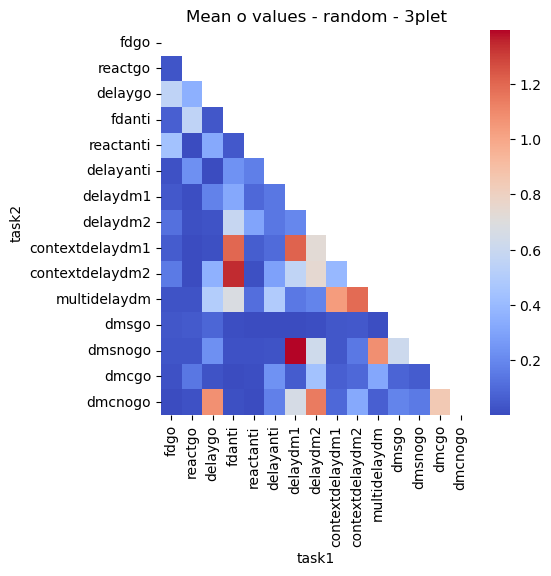

In [18]:

#just use the random task and order = 3
subselect_meanhoi = concatenated_meanhoi[(concatenated_meanhoi['order'] == 3) & (concatenated_meanhoi['task'] == 'random')]
# Create a pivot table with tasks list as the order reference
pivot_table = subselect_meanhoi.pivot(index='task2', columns='task1', values='o').reindex(index=tasks, columns=tasks)
# Create a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(pivot_table, cmap='coolwarm')#, cbar_kws={'label': 'o'}), annot=True
plt.title('Mean o values - random - 3plet')
plt.show()


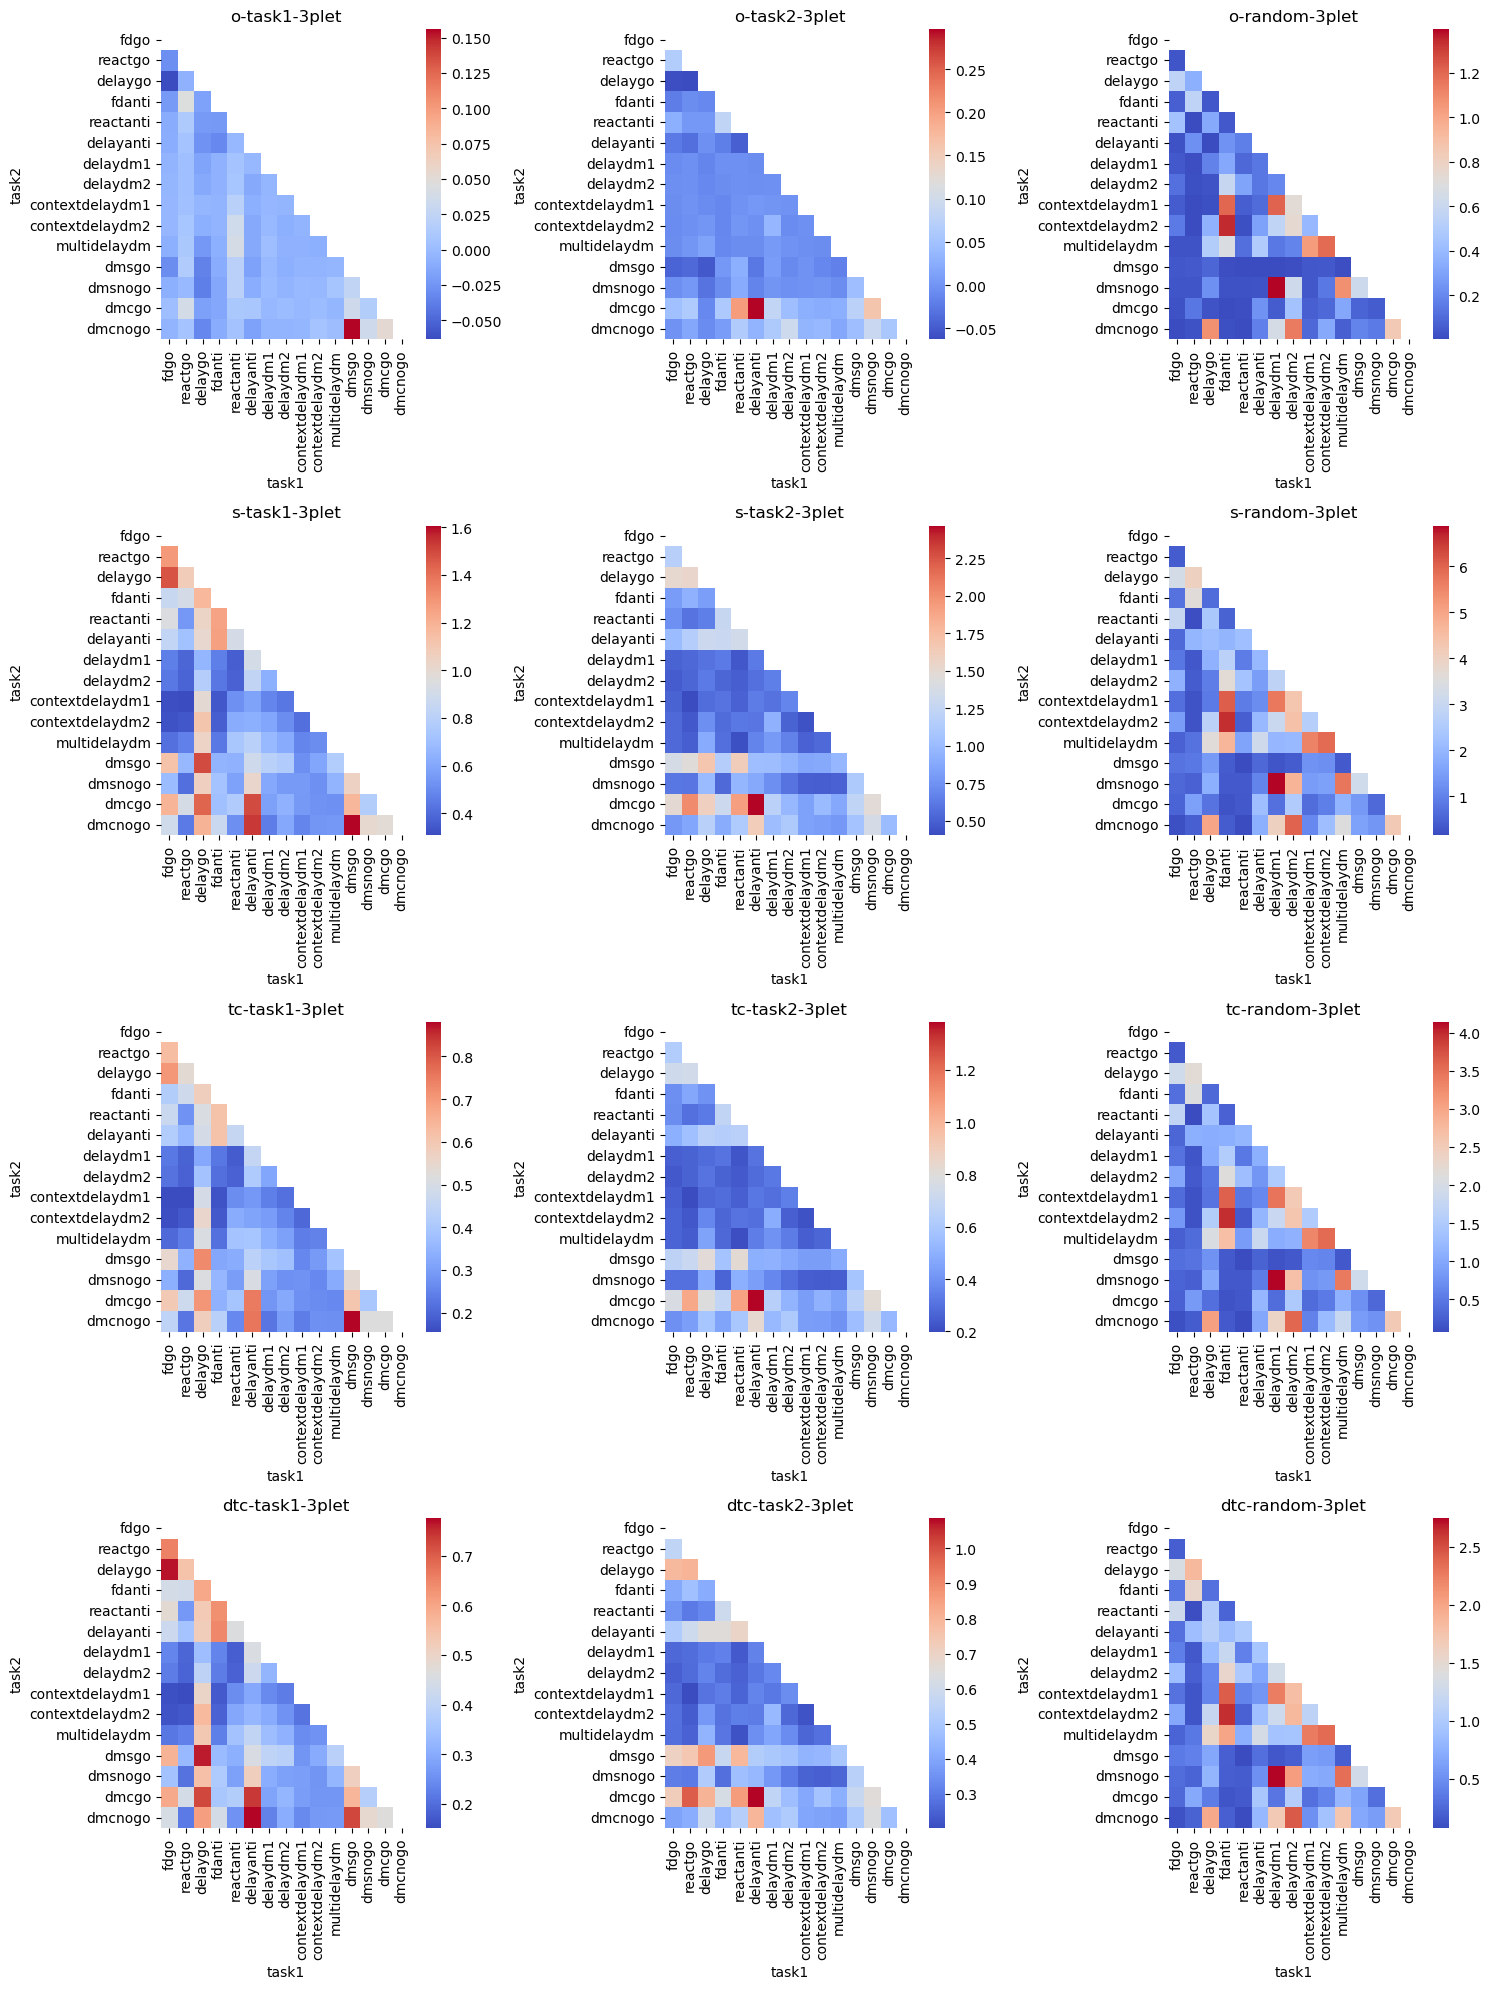

In [23]:

#just use the random task and order = 3
fig,axes = plt.subplots(4,3,figsize=(15,20))
axes = axes.flatten()
axcounter = 0
for metricind,metric in enumerate(["o","s","tc","dtc"]):
    for taskind,task in enumerate(["task1","task2","random"]):
        if task == "random":
            subselect_meanhoi = concatenated_meanhoi[(concatenated_meanhoi['order'] == 3) & (concatenated_meanhoi['task'] == 'random')]
        else:
            subselect_meanhoi = concatenated_meanhoi[(concatenated_meanhoi['order'] == 3) & (concatenated_meanhoi['task'] == concatenated_meanhoi[task])]
        # Create a pivot table with tasks list as the order reference
        pivot_table = subselect_meanhoi.pivot(index='task2', columns='task1', values=metric).reindex(index=tasks, columns=tasks)        
        # Create a heatmap
        #plt.figure(figsize=(5, 5))
        sns.heatmap(pivot_table, cmap='coolwarm',ax=axes[axcounter] )#, cbar_kws={'label': 'o'}), annot=True
        axes[axcounter].set_title(f'{metric}-{task}-3plet')
        #plt.show()
        axcounter+=1
plt.tight_layout()
plt.show()
